I am tasked with working for an investor who specializes in purchasing undervalued assets. The investor wants to perform detailed data analysis to identify opportunities for growth and profitability in a potential purchase—TellCo, a mobile service provider in the Republic of Pefkakia. Your goal is to analyze customer data, provide insights, and make recommendations on whether TellCo is worth buying or selling. The analysis will be presented through a web-based dashboard and a written report.
Task 2: User Engagement Analysis
Objective: Assess user engagement using metrics such as session frequency, duration, and total traffic.

Aggregate engagement metrics per customer and report top customers.

Normalize metrics and classify customers into three engagement groups using k-means clustering.

Compute and visualize engagement metrics for each cluster.

Aggregate user traffic per application and identify top users.

Plot top 3 most used applications.

Optimize k-value for k-means clustering and interpret findings.


In [1]:
import sys 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from dotenv import load_dotenv
from sqlalchemy import create_engine
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
os.chdir('..')
sys.path.append(os.getcwd())
#from scripts.DB_connection  import PostgresConnection
from src.Eda import missing_values_table, convert_bytes_to_megabytes

In [2]:
from scripts.DB_connection import PostgresConnection

# Establishing the database connection
db = PostgresConnection()
db.connect()

if db.conn:
    # Example query
    query = "SELECT * FROM xdr_data"
    result = db.execute_query(query)

    if result:
        # Convert the result to a Pandas DataFrame
        df = pd.DataFrame(result, columns=[desc[0] for desc in db.cursor.description])
        print(df.head())  # Display the first few rows of the DataFrame
    else:
        print("No results returned from the query.")
    
    # Close the connection when done
    db.close_connection()
else:
    print("Error: No database connection.")

Connected to PostgreSQL database!
      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...         

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Bearer Id                                 149010 non-null  float64
 1   Start                                     150000 non-null  object 
 2   Start ms                                  150000 non-null  float64
 3   End                                       150000 non-null  object 
 4   End ms                                    150000 non-null  float64
 5   Dur. (ms)                                 150000 non-null  float64
 6   IMSI                                      149431 non-null  float64
 7   MSISDN/Number                             148935 non-null  float64
 8   IMEI                                      149429 non-null  float64
 9   Last Location Name                        148848 non-null  object 
 10  Avg RTT DL (ms)     

Extract User engagement columns

In [5]:
user_engagement_columns = [
    # Identifiers
    'IMSI', 'MSISDN/Number',

    # Session Duration Columns
    'Dur. (ms)', 'Activity Duration DL (ms)', 'Activity Duration UL (ms)',

    # Data Traffic Columns (Download and Upload)
    'Total DL (Bytes)', 'Total UL (Bytes)',
    'Social Media DL (Bytes)', 'Social Media UL (Bytes)',
    'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
    'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
    'Google DL (Bytes)', 'Google UL (Bytes)',
    'Email DL (Bytes)', 'Email UL (Bytes)',
    'Gaming DL (Bytes)', 'Gaming UL (Bytes)',
    'Other DL (Bytes)', 'Other UL (Bytes)',

    # QoS Columns
    'Avg RTT DL (ms)', 'Avg RTT UL (ms)',
    'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)'
]

In [6]:
# Creating the df_user_engagement DataFrame with the selected columns
df_user_engagement = df[user_engagement_columns].copy()

EDA on extracted data

In [10]:
df_user_engagement.head()

,IMSI,MSISDN/Number,Dur. (ms),Activity Duration DL (ms),Activity Duration UL (ms),Total DL (Bytes),Total UL (Bytes),Social Media DL (Bytes),Social Media UL (Bytes),Youtube DL (Bytes),...,Email DL (Bytes),Email UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps)
0,2.082014e+14,3.366496e+10,1823652.0,37624.0,38787.0,308879636.0,36749741.0,1545765.0,24420.0,15854611.0,...,3563542.0,137762.0,278082303.0,14344150.0,171744450.0,8814393.0,42.0,5.0,23.0,44.0
1,2.082019e+14,3.368185e+10,1365104.0,168.0,3560.0,653384965.0,53800391.0,1926113.0,7165.0,20247395.0,...,629046.0,308339.0,608750074.0,1170709.0,526904238.0,15055145.0,65.0,5.0,16.0,26.0
2,2.082003e+14,3.376063e+10,1361762.0,0.0,0.0,279807335.0,27883638.0,1684053.0,42224.0,19725661.0,...,2690151.0,672973.0,229584621.0,395630.0,410692588.0,4215763.0,NaN,NaN,6.0,9.0
3,2.082014e+14,3.375034e+10,1321509.0,3330.0,37882.0,846028530.0,43324218.0,644121.0,13372.0,21388122.0,...,1439754.0,631229.0,799538153.0,10849722.0,749039933.0,12797283.0,NaN,NaN,44.0,44.0
4,2.082014e+14,3.369980e+10,1089009.0,0.0,0.0,569138589.0,38542814.0,862600.0,50188.0,15259380.0,...,1936496.0,173853.0,527707248.0,3529801.0,550709500.0,13910322.0,NaN,NaN,6.0,9.0


In [8]:
df_user_engagement.shape

(150001, 25)

In [7]:
#check the missing 
from src.Eda import missing_values_table
missing_values_table(df_user_engagement)

Your selected dataframe has 25 columns.
There are 11 columns that have missing values.


,Missing Values,% of Total Values,Dtype
Avg RTT DL (ms),27829,18.6,float64
Avg RTT UL (ms),27812,18.5,float64
MSISDN/Number,1066,0.7,float64
IMSI,570,0.4,float64
Dur. (ms),1,0.0,float64
Activity Duration DL (ms),1,0.0,float64
Activity Duration UL (ms),1,0.0,float64
Total UL (Bytes),1,0.0,float64
Total DL (Bytes),1,0.0,float64
Avg Bearer TP DL (kbps),1,0.0,float64


In [10]:
df_user_engagement.dropna(subset=['MSISDN/Number'], inplace=True)
missing_values_table(df_user_engagement)

Your selected dataframe has 25 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values,Dtype
Avg RTT DL (ms),27644,18.6,float64
Avg RTT UL (ms),27625,18.5,float64


In [11]:
#replace the above missing values with the mean of the column
mean_rtt_dl = df_user_engagement['Avg RTT DL (ms)'].mean()
mean_rtt_ul = df_user_engagement['Avg RTT UL (ms)'].mean()

# Fill missing values with mean
df_user_engagement['Avg RTT DL (ms)'].fillna(mean_rtt_dl, inplace=True)
df_user_engagement['Avg RTT UL (ms)'].fillna(mean_rtt_ul, inplace=True)

C:\Users\Dagi\AppData\Local\Temp\ipykernel_9140\304125833.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_user_engagement['Avg RTT DL (ms)'].fillna(mean_rtt_dl, inplace=True)
C:\Users\Dagi\AppData\Local\Temp\ipykernel_9140\304125833.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as

In [12]:
df_user_engagement.isnull().sum()

IMSI                         0
MSISDN/Number                0
Dur. (ms)                    0
Activity Duration DL (ms)    0
Activity Duration UL (ms)    0
Total DL (Bytes)             0
Total UL (Bytes)             0
Social Media DL (Bytes)      0
Social Media UL (Bytes)      0
Youtube DL (Bytes)           0
Youtube UL (Bytes)           0
Netflix DL (Bytes)           0
Netflix UL (Bytes)           0
Google DL (Bytes)            0
Google UL (Bytes)            0
Email DL (Bytes)             0
Email UL (Bytes)             0
Gaming DL (Bytes)            0
Gaming UL (Bytes)            0
Other DL (Bytes)             0
Other UL (Bytes)             0
Avg RTT DL (ms)              0
Avg RTT UL (ms)              0
Avg Bearer TP DL (kbps)      0
Avg Bearer TP UL (kbps)      0
dtype: int64

there is no missing values in the above cell

In [13]:
byte_columns = [
    'Total DL (Bytes)', 'Total UL (Bytes)',
    'Social Media DL (Bytes)', 'Social Media UL (Bytes)',
    'YouTube DL (Bytes)', 'YouTube UL (Bytes)',
    'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
    'Google DL (Bytes)', 'Google UL (Bytes)',
    'Email DL (Bytes)', 'Email UL (Bytes)',
    'Gaming DL (Bytes)', 'Gaming UL (Bytes)',
    'Other DL (Bytes)', 'Other UL (Bytes)'
]

In [14]:
for column in byte_columns:
    if column in df_user_engagement.columns:
        df_user_engagement[column] = df_user_engagement[column].apply(convert_bytes_to_megabytes)

In [15]:
millisecond_columns_to_convert = [
    'Dur. (ms)',
    'Activity Duration DL (ms)',
    'Activity Duration UL (ms)',
    'Avg RTT DL (ms)',
    'Avg RTT UL (ms)'
]

In [17]:
from src.Eda import convert_ms_to_seconds
for column in millisecond_columns_to_convert:
    if column in df_user_engagement.columns:
        df_user_engagement[column] = df_user_engagement[column].apply(convert_ms_to_seconds)

In [18]:
#Renaming the converted colums
df_user_engagement.rename(columns=lambda x: x.replace('Bytes', 'Megabytes') if 'Bytes' in x else x, inplace=True)
df_user_engagement.rename(columns=lambda x: x.replace('(ms)', '(s)') if '(ms)' in x else x, inplace=True)

In [19]:
df_user_engagement.head()

,IMSI,MSISDN/Number,Dur. (s),Activity Duration DL (s),Activity Duration UL (s),Total DL (Megabytes),Total UL (Megabytes),Social Media DL (Megabytes),Social Media UL (Megabytes),Youtube DL (Megabytes),...,Email DL (Megabytes),Email UL (Megabytes),Gaming DL (Megabytes),Gaming UL (Megabytes),Other DL (Megabytes),Other UL (Megabytes),Avg RTT DL (s),Avg RTT UL (s),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps)
0,2.082014e+14,3.366496e+10,1823.652,37.624,38.787,294.570576,35.047284,1.474156,0.023289,15854611.0,...,3.398458,0.131380,265.199950,13.679647,163.788271,8.406060,0.042000,0.005000,23.0,44.0
1,2.082019e+14,3.368185e+10,1365.104,0.168,3.560,623.116460,51.308051,1.836884,0.006833,20247395.0,...,0.599905,0.294055,580.549311,1.116475,502.495039,14.357705,0.065000,0.005000,16.0,26.0
2,2.082003e+14,3.376063e+10,1361.762,0.000,0.000,266.845069,26.591909,1.606038,0.040268,19725661.0,...,2.565528,0.641797,218.948956,0.377302,391.666973,4.020465,0.108225,0.017637,6.0,9.0
3,2.082014e+14,3.375034e+10,1321.509,3.330,37.882,806.835680,41.317194,0.614282,0.012753,21388122.0,...,1.373056,0.601987,762.499002,10.347101,714.340146,12.204440,0.108225,0.017637,44.0,44.0
4,2.082014e+14,3.369980e+10,1089.009,0.000,0.000,542.772855,36.757292,0.822639,0.047863,15259380.0,...,1.846786,0.165799,503.260849,3.366281,525.197506,13.265917,0.108225,0.017637,6.0,9.0


grouping data by mssisdn and aggregating the data

In [20]:
grouped_df = df_user_engagement.groupby('MSISDN/Number').agg({
    'Dur. (s)': 'sum',
    'Total DL (Megabytes)': 'sum',
    'Total UL (Megabytes)': 'sum',
    'Activity Duration DL (s)': 'sum',
    'Activity Duration UL (s)': 'sum'
}).reset_index()

In [21]:
grouped_df['Total Traffic (Megabytes)'] = grouped_df['Total DL (Megabytes)'] + grouped_df['Total UL (Megabytes)']


Sorting and Reporting Top 10 Customers

In [22]:
top_10_duration = grouped_df.sort_values(by='Dur. (s)', ascending=False).head(10)
top_10_download = grouped_df.sort_values(by='Total DL (Megabytes)', ascending=False).head(10)
top_10_upload = grouped_df.sort_values(by='Total UL (Megabytes)', ascending=False).head(10)
print("Top 10 customers by session duration:")
print(top_10_duration)

Top 10 customers by session duration:
       MSISDN/Number   Dur. (s)  Total DL (Megabytes)  Total UL (Megabytes)  \
13180   3.362578e+10  18553.754           7410.090773            695.779209   
6437    3.361489e+10   9966.898           7778.876775            657.542230   
92923   3.376054e+10   9279.434           7449.431784            670.889455   
13526   3.362632e+10   8791.927           6963.268795            638.628694   
65118   3.366716e+10   8744.914           4818.027201            540.090908   
50281   3.366284e+10   6614.270           3427.194222            387.596485   
57160   3.366469e+10   6288.730           5035.234957            383.549503   
666     3.360313e+10   6287.761           4330.260670            415.408736   
66029   3.366746e+10   5649.882           2226.161283            253.889701   
92577   3.376041e+10   5321.667           6304.599403            497.359171   

       Activity Duration DL (s)  Activity Duration UL (s)  \
13180                   920.307

In [23]:
print("Top 10 customers by total download traffic:")
top_10_download.head(10)

Top 10 customers by total download traffic:


,MSISDN/Number,Dur. (s),Total DL (Megabytes),Total UL (Megabytes),Activity Duration DL (s),Activity Duration UL (s),Total Traffic (Megabytes)
6437,3.361489e+10,9966.898,7778.876775,657.542230,11033.881,10625.107,8436.419004
92923,3.376054e+10,9279.434,7449.431784,670.889455,7167.513,6634.298,8120.321239
13180,3.362578e+10,18553.754,7410.090773,695.779209,920.307,889.205,8105.869982
76363,3.367588e+10,4865.947,6970.922295,554.627220,18439.694,18075.788,7525.549515
13526,3.362632e+10,8791.927,6963.268795,638.628694,1859.652,1487.868,7601.897489
37052,3.365973e+10,4035.428,6753.542387,595.341035,8941.911,8615.995,7348.883422
63028,3.366646e+10,4536.757,6583.633387,386.296249,1397.206,1260.089,6969.929636
92577,3.376041e+10,5321.667,6304.599403,497.359171,4560.073,4127.592,6801.958574
57241,3.366471e+10,2927.785,6104.253535,449.413732,6781.566,6352.855,6553.667267
86455,3.369879e+10,5169.128,5732.112905,505.774598,3671.040,3503.941,6237.887503


In [24]:
print("Top 10 customers by total upload traffic:")
top_10_upload.head(10)

Top 10 customers by total upload traffic:


,MSISDN/Number,Dur. (s),Total DL (Megabytes),Total UL (Megabytes),Activity Duration DL (s),Activity Duration UL (s),Total Traffic (Megabytes)
13180,3.362578e+10,18553.754,7410.090773,695.779209,920.307,889.205,8105.869982
92923,3.376054e+10,9279.434,7449.431784,670.889455,7167.513,6634.298,8120.321239
6437,3.361489e+10,9966.898,7778.876775,657.542230,11033.881,10625.107,8436.419004
13526,3.362632e+10,8791.927,6963.268795,638.628694,1859.652,1487.868,7601.897489
37052,3.365973e+10,4035.428,6753.542387,595.341035,8941.911,8615.995,7348.883422
76363,3.367588e+10,4865.947,6970.922295,554.627220,18439.694,18075.788,7525.549515
65118,3.366716e+10,8744.914,4818.027201,540.090908,537.698,466.253,5358.118109
86455,3.369879e+10,5169.128,5732.112905,505.774598,3671.040,3503.941,6237.887503
92577,3.376041e+10,5321.667,6304.599403,497.359171,4560.073,4127.592,6801.958574
94654,3.376127e+10,3481.629,4343.650218,473.467924,19396.439,19363.363,4817.118142


Session Frequency

In [25]:
session_frequency = df_user_engagement.groupby('MSISDN/Number').size().reset_index(name='Session Frequency')
grouped_df = grouped_df.merge(session_frequency, on='MSISDN/Number')
top_10_session_frequency = grouped_df.sort_values(by='Session Frequency', ascending=False).head(10)
print("Top 10 customers by session frequency:")
top_10_session_frequency.head(10)

Top 10 customers by session frequency:


,MSISDN/Number,Dur. (s),Total DL (Megabytes),Total UL (Megabytes),Activity Duration DL (s),Activity Duration UL (s),Total Traffic (Megabytes),Session Frequency
13526,3.362632e+10,8791.927,6963.268795,638.628694,1859.652,1487.868,7601.897489,18
6437,3.361489e+10,9966.898,7778.876775,657.542230,11033.881,10625.107,8436.419004,17
13180,3.362578e+10,18553.754,7410.090773,695.779209,920.307,889.205,8105.869982,17
37052,3.365973e+10,4035.428,6753.542387,595.341035,8941.911,8615.995,7348.883422,16
76363,3.367588e+10,4865.947,6970.922295,554.627220,18439.694,18075.788,7525.549515,15
92923,3.376054e+10,9279.434,7449.431784,670.889455,7167.513,6634.298,8120.321239,15
65118,3.366716e+10,8744.914,4818.027201,540.090908,537.698,466.253,5358.118109,13
1279,3.360452e+10,5207.990,4860.000073,373.626572,19278.150,12381.164,5233.626645,12
92577,3.376041e+10,5321.667,6304.599403,497.359171,4560.073,4127.592,6801.958574,12
666,3.360313e+10,6287.761,4330.260670,415.408736,7203.344,6938.296,4745.669406,12


In [31]:
#Normalization and K-means clustering
columns_to_normalize = ['Dur. (s)', 'Total DL (Megabytes)', 'Total UL (Megabytes)', 'Session Frequency']
scaler = MinMaxScaler()
# Fit and transform the selected columns
grouped_df[columns_to_normalize] = scaler.fit_transform(grouped_df[columns_to_normalize])

In [32]:
#K-Means Clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
grouped_df['Cluster'] = kmeans.fit_predict(grouped_df[columns_to_normalize])
#cluster centers to see the characteristics of each cluster
print("Cluster Centers (Centroids):")
print(kmeans.cluster_centers_)

c:\Users\Dagi\Documents\KAIM\Week-2\User-Overview-Engagement-and-Experience-Analysis\week-2\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Dagi\Documents\KAIM\Week-2\User-Overview-Engagement-and-Experience-Analysis\week-2\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec

Cluster Centers (Centroids):
[[0.01094607 0.12005584 0.11850889 0.06775035]
 [0.00527986 0.05462632 0.05332706 0.00113112]
 [0.03011489 0.25145438 0.23957346 0.19066115]]


In [33]:
#Grouping by Cluster and Calculate Statistics
cluster_stats = grouped_df.groupby('Cluster').agg({
    'Dur. (s)': ['min', 'max', 'mean', 'sum'],
    'Total DL (Megabytes)': ['min', 'max', 'mean', 'sum'],
    'Total UL (Megabytes)': ['min', 'max', 'mean', 'sum'],
    'Session Frequency': ['min', 'max', 'mean', 'sum']
}).reset_index()
cluster_stats

Cluster  Dur. (s)                                 Total DL (Megabytes)  \
                min       max      mean         sum                  min   
0       0  0.000598  0.170796  0.010947  256.267164             0.008315   
1       1  0.000000  0.084451  0.005280  418.494003             0.000000   
2       2  0.002143  1.000000  0.030141  126.229985             0.063411   

                                   Total UL (Megabytes)                      \
        max      mean          sum                  min       max      mean   
0  0.264748  0.120094  2811.282709             0.031692  0.268026  0.118525   
1  0.109739  0.054626  4329.578655             0.000000  0.140513  0.053330   
2  1.000000  0.251534  1053.425472             0.103420  1.000000  0.239700   

               Session Frequency                                   
           sum               min       max      mean          sum  
0  2774.540699          0.058824  0.176471  0.067769  1586.411765  
1  4226.859991          0.000000  0.058824  0.001134    89.882353  
2  1003.865679          0.117647  1.000000  0.190769   798.941176

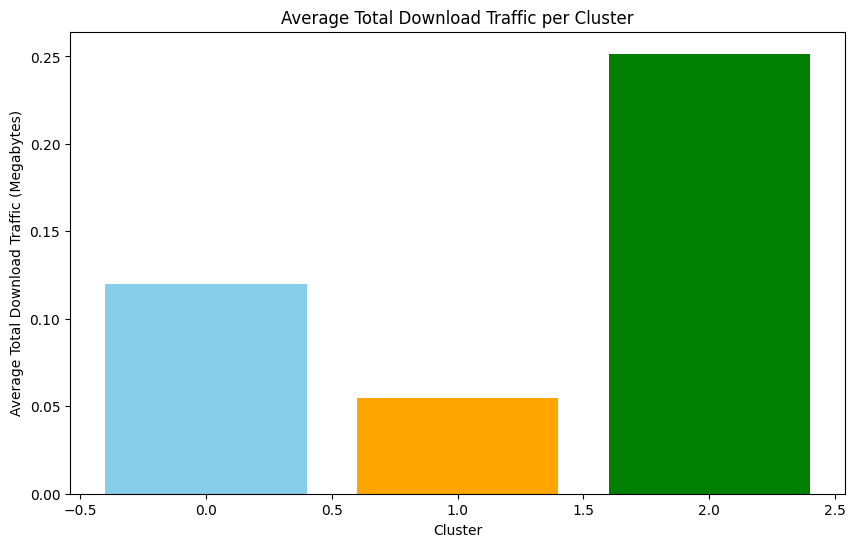

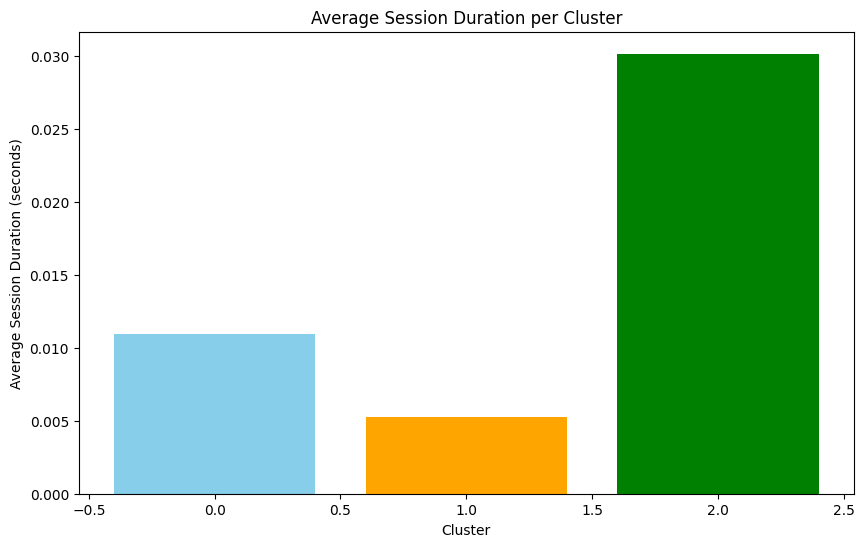

In [34]:
#Visualization of the Clusters
# Plotting average total download traffic per cluster
plt.figure(figsize=(10, 6))
plt.bar(cluster_stats['Cluster'], cluster_stats['Total DL (Megabytes)']['mean'], color=['skyblue', 'orange', 'green'])
plt.title("Average Total Download Traffic per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Total Download Traffic (Megabytes)")
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(cluster_stats['Cluster'], cluster_stats['Dur. (s)']['mean'], color=['skyblue', 'orange', 'green'])
plt.title("Average Session Duration per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Session Duration (seconds)")
plt.show()

In [39]:
applications = {
    'Social Media': ('Social Media DL (Megabytes)', 'Social Media UL (Megabytes)'),
    'Youtube': ('Youtube DL (Megabytes)', 'Youtube UL (Megabytes)'),
    'Netflix': ('Netflix DL (Megabytes)', 'Netflix UL (Megabytes)'),
    'Google': ('Google DL (Megabytes)', 'Google UL (Megabytes)'),
    'Email': ('Email DL (Megabytes)', 'Email UL (Megabytes)'),
    'Gaming': ('Gaming DL (Megabytes)', 'Gaming UL (Megabytes)'),
    'Other': ('Other DL (Megabytes)', 'Other UL (Megabytes)')
}

In [40]:
top_users_per_app = {}

In [41]:
for app, (dl_col, ul_col) in applications.items():
    print(f"\nProcessing {app}...")

    # Check if the columns exist in the DataFrame
    if dl_col in df_user_engagement.columns and ul_col in df_user_engagement.columns:
        # Aggregate total traffic (DL + UL) per user
        total_traffic_per_user = (
            df_user_engagement.groupby('MSISDN/Number')[[dl_col, ul_col]]
            .sum()
            .sum(axis=1)  # Sum DL and UL
            .reset_index(name='Total Traffic')
            .sort_values(by='Total Traffic', ascending=False)
            .head(10)
        )
        
        # Store the top 10 users for the current application
        top_users_per_app[app] = total_traffic_per_user
        
        # Print the top 10 users
        print(f"Top 10 Most Engaged Users for {app}:")
        print(total_traffic_per_user)
        print("\n")
    else:
        print(f"Columns '{dl_col}' or '{ul_col}' not found in DataFrame.")
        print("\n")


Processing Social Media...
Top 10 Most Engaged Users for Social Media:
        MSISDN/Number  Total Traffic
13526    3.362632e+10      41.365413
92923    3.376054e+10      37.940206
37052    3.365973e+10      33.771856
6437     3.361489e+10      26.983780
13180    3.362578e+10      25.878429
65118    3.366716e+10      23.124552
106137   3.378632e+10      22.864264
70960    3.366907e+10      22.698244
666      3.360313e+10      22.008729
31331    3.365849e+10      21.934572



Processing Youtube...
Top 10 Most Engaged Users for Youtube:
       MSISDN/Number  Total Traffic
13180   3.362578e+10    452958769.0
92923   3.376054e+10    396289198.0
6437    3.361489e+10    394370218.0
13526   3.362632e+10    374483047.0
76363   3.367588e+10    317410572.0
65118   3.366716e+10    315231310.0
13994   3.362708e+10    308790774.0
92577   3.376041e+10    303169107.0
86455   3.369879e+10    302661958.0
666     3.360313e+10    284090139.0



Processing Netflix...
Top 10 Most Engaged Users for Netfli

In [42]:
#Plotting the top 3 most used applications
total_traffic_per_app = {}

In [43]:
# Calculate total traffic for each application
for app, (dl_col, ul_col) in applications.items():
    if dl_col in df_user_engagement.columns and ul_col in df_user_engagement.columns:
        # Aggregate total traffic (DL + UL) per user
        total_traffic = (
            df_user_engagement[[dl_col, ul_col]]
            .sum()  # Sum DL and UL for all users
        ).sum()  # Sum across all applications
        
        # Store the total traffic for the current application
        total_traffic_per_app[app] = total_traffic
# Convert the dictionary to a DataFrame for easier plotting
traffic_df = pd.DataFrame(list(total_traffic_per_app.items()), columns=['Application', 'Total Traffic'])

# Sort applications by total traffic and get the top 3
top_3_apps = traffic_df.sort_values(by='Total Traffic', ascending=False).head(3)
top_3_apps

,Application,Total Traffic
1,Youtube,3.372204e+12
5,Gaming,6.111995e+07
6,Other,6.099153e+07


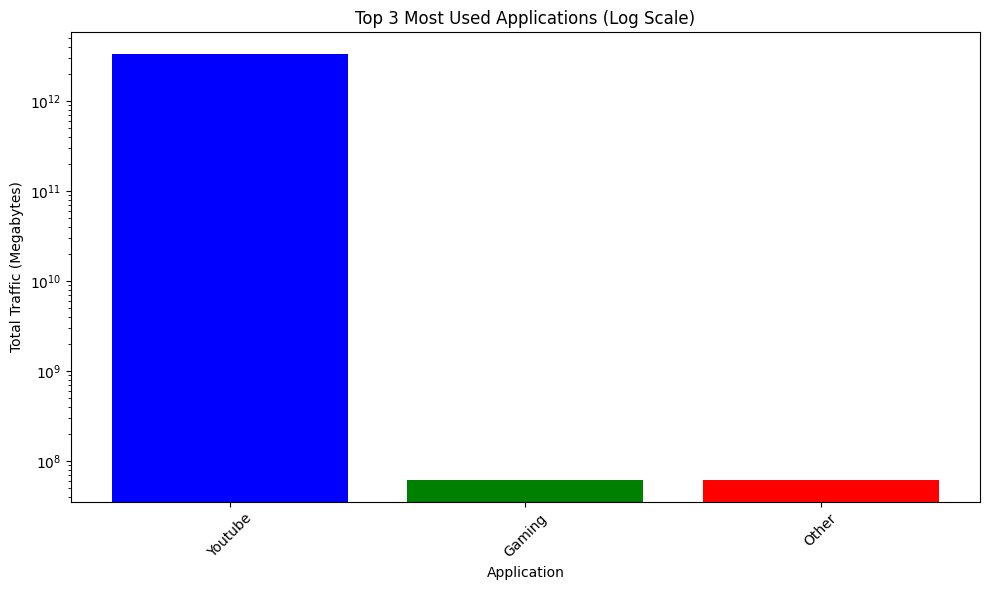

In [44]:
# Plot the top 3 most used applications with a logarithmic scale
plt.figure(figsize=(10, 6))
plt.bar(top_3_apps['Application'], top_3_apps['Total Traffic'], color=['blue', 'green', 'red'])
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xlabel('Application')
plt.ylabel('Total Traffic (Megabytes)')
plt.title('Top 3 Most Used Applications (Log Scale)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import os



# Step 1: Aggregate the engagement metrics per customer
session_frequency = df_user_engagement.groupby('MSISDN/Number').size().reset_index(name='Session Frequency')
session_duration = df_user_engagement.groupby('MSISDN/Number')['Dur. (ms)'].sum().reset_index(name='Session Duration')
total_traffic = df_user_engagement.groupby('MSISDN/Number').agg(
    total_traffic_ul=('Total UL (Bytes)', 'sum'),
    total_traffic_dl=('Total DL (Bytes)', 'sum')
).reset_index()
total_traffic['Total Traffic (Bytes)'] = total_traffic['total_traffic_ul'] + total_traffic['total_traffic_dl']
total_traffic.drop(columns=['total_traffic_ul', 'total_traffic_dl'], inplace=True)

# Step 2: Merge the metrics into one DataFrame
engagement_metrics = pd.merge(session_frequency, session_duration, on='MSISDN/Number')
engagement_metrics = pd.merge(engagement_metrics, total_traffic[['MSISDN/Number', 'Total Traffic (Bytes)']], on='MSISDN/Number')

# Step 3: Normalize each engagement metric using StandardScaler
scaler = StandardScaler()
engagement_metrics[['Session Frequency', 'Session Duration', 'Total Traffic (Bytes)']] = scaler.fit_transform(
    engagement_metrics[['Session Frequency', 'Session Duration', 'Total Traffic (Bytes)']]
)

# Step 4: Perform k-means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
engagement_metrics['Engagement Cluster'] = kmeans.fit_predict(engagement_metrics[['Session Frequency', 'Session Duration', 'Total Traffic (Bytes)']])

# Step 5: Label the clusters for better readability
cluster_labels = {0: 'Low Engagement', 1: 'Medium Engagement', 2: 'High Engagement'}
engagement_metrics['Engagement Cluster Label'] = engagement_metrics['Engagement Cluster'].map(cluster_labels)

# Step 6: Retrieve the centroids in the scaled space
centroids_scaled = kmeans.cluster_centers_

# Step 7: Inverse transform the centroids to get them back to the original scale
centroids_original = scaler.inverse_transform(centroids_scaled)

# Step 8: Create a DataFrame to store centroids with descriptive cluster names
centroid_engagement = pd.DataFrame(centroids_original, columns=[
    'Session Frequency', 'Session Duration', 'Total Traffic (Bytes)'
])
centroid_engagement['Cluster Name'] = [cluster_labels[i] for i in range(len(centroids_original))]

# Set 'Cluster Name' as the index for easier referencing
centroid_engagement.set_index('Cluster Name', inplace=True)

# Print the centroids for reference
print("Centroids of Engagement Clusters (Original Scale):")
print(centroid_engagement)

# Save the centroid_engagement DataFrame to a CSV file
file_path = 'centroid_engagement.csv'
centroid_engagement.to_csv(file_path, index=True)

# Display the path to the saved file
print(f"\nCentroid Engagement DataFrame saved to: {os.path.abspath(file_path)}")

# Brief description of each cluster based on the average of engagement metrics
cluster_description = engagement_metrics.groupby('Engagement Cluster Label')[[
    'Session Frequency', 'Session Duration', 'Total Traffic (Bytes)'
]].mean()

# Print the cluster descriptions
print("\nCluster Descriptions (Averages of Engagement Metrics):")
for group_name in cluster_description.index:
    print(f"\n{group_name}:")
    print(f"- Average Session Frequency: {cluster_description.loc[group_name, 'Session Frequency']:.2f}")
    print(f"- Average Session Duration: {cluster_description.loc[group_name, 'Session Duration']:.2f} ms")
    print(f"- Average Total Traffic: {cluster_description.loc[group_name, 'Total Traffic (Bytes)']:.2f} Bytes")

c:\Users\Dagi\Documents\KAIM\Week-2\User-Overview-Engagement-and-Experience-Analysis\week-2\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Dagi\Documents\KAIM\Week-2\User-Overview-Engagement-and-Experience-Analysis\week-2\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec

Centroids of Engagement Clusters (Original Scale):
                   Session Frequency  Session Duration  Total Traffic (Bytes)
Cluster Name                                                                 
Low Engagement              2.180022     214742.578132           1.113469e+09
Medium Engagement           1.027237     103083.634717           4.948823e+08
High Engagement             4.397993     655288.439521           2.285340e+09

Centroid Engagement DataFrame saved to: c:\Users\Dagi\Documents\KAIM\Week-2\User-Overview-Engagement-and-Experience-Analysis\centroid_engagement.csv

Cluster Descriptions (Averages of Engagement Metrics):

High Engagement:
- Average Session Frequency: 3.73
- Average Session Duration: 2.74 ms
- Average Total Traffic: 3.25 Bytes

Low Engagement:
- Average Session Frequency: 0.98
- Average Session Duration: 0.37 ms
- Average Total Traffic: 0.86 Bytes

Medium Engagement:
- Average Session Frequency: -0.45
- Average Session Duration: -0.23 ms
- Average Tota